## Cleaning and Modeling - Spaceship Titanic Kaggle Competition

In [ ]:
pip install XGBoost

In [1]:
import boto3
import pandas as pd
import numpy as np
import cleaning
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
pd.set_option('display.max_columns', 50)

In [2]:
## Defining the bucket
s3 = boto3.resource('s3')
bucket_name = 'data-448-bucket-callaghan'
bucket = s3.Bucket(bucket_name)

## Using pandas to read the data files

file_key = 'titanic_train.csv'
file_key2 = 'titanic_test.csv'

bucket_object = bucket.Object(file_key)
bucket_object2 = bucket.Object(file_key2)

file_object = bucket_object.get()
file_object2 = bucket_object2.get()

file_content_stream = file_object.get('Body')
file_content_stream2 = file_object2.get('Body')

train = pd.read_csv(file_content_stream)
test = pd.read_csv(file_content_stream2)

train.head()

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


### Data Cleaning / Feature Engineering

In [3]:
## Looking at missing values:

print('Training:', train.isnull().sum())

print('\nTesting:', test.isnull().sum())

Training: PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

Testing: PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64


In [4]:
## Extracting group number and passenger number from PassengerID variable
  
## Creating a new data frame with split value columns
split = train['PassengerId'].str.split('_', n = 1, expand = True)

# Defining new columns from split data frame
train['GroupNumber'] = split[0]
train['GroupPerson'] = split[1]

## Chaging GroupPeople to int
train['GroupPerson'] = train['GroupPerson'].astype(int)


## Creating a new data frame with split value columns
split = test['PassengerId'].str.split('_', n = 1, expand = True)

# Defining new columns from split data frame
test['GroupNumber']= split[0]
test['GroupPerson']= split[1]

## Chaging GroupPeople to int
test['GroupPerson'] = test['GroupPerson'].astype(int)

In [5]:
## Creating GroupPeopleTotal variables

## Creating new temp data frame
totals = pd.DataFrame(train.groupby('GroupNumber')['GroupPerson'].max()).reset_index(drop = False)

## Renaming columns
totals.rename(columns = {'GroupPerson':'GroupTotal'}, inplace = True)

## Joining the data frames
train = train.merge(totals, how = 'left')


## Creating new temp data frame
totals = pd.DataFrame(test.groupby('GroupNumber')['GroupPerson'].max()).reset_index(drop = False)

## Renaming columns
totals.rename(columns = {'GroupPerson':'GroupTotal'}, inplace = True)

## Joining the data frames
test = test.merge(totals, how = 'left')

In [6]:
## Cleaning HomePlanet variable using the clean_method_mode function

train = cleaning.clean_method_mode(train, 'HomePlanet')
test = cleaning.clean_method_mode(test, 'HomePlanet')

In [7]:
## Cleaning Destination variable using the clean_method_mode function

train = cleaning.clean_method_mode(train, 'Destination')
test = cleaning.clean_method_mode(test, 'Destination')

In [8]:
## Cleaning Age variable using the clean_method_mean function

train = cleaning.clean_method_mean(train, 'Age')
test = cleaning.clean_method_mean(test, 'Age')

In [9]:
## Cleaning RoomService, FoodCourt, ShoppingMall, Spa, and VRDeck variables using the clean_method_zero function

train = cleaning.clean_method_zero(train, 'RoomService')
train = cleaning.clean_method_zero(train, 'FoodCourt')
train = cleaning.clean_method_zero(train, 'ShoppingMall')
train = cleaning.clean_method_zero(train, 'Spa')
train = cleaning.clean_method_zero(train, 'VRDeck')

test = cleaning.clean_method_zero(test, 'RoomService')
test = cleaning.clean_method_zero(test, 'FoodCourt')
test = cleaning.clean_method_zero(test, 'ShoppingMall')
test = cleaning.clean_method_zero(test, 'Spa')
test = cleaning.clean_method_zero(test, 'VRDeck')

In [10]:
## Cleaning Name variable using the clean_method_string function

train = cleaning.clean_method_string(train, 'Name')
test = cleaning.clean_method_string(test, 'Name')

In [11]:
## Cleaning CryoSleep and VIP variables using the clean_method_boolean function

train = cleaning.clean_method_boolean(train, 'CryoSleep')
train = cleaning.clean_method_boolean(train, 'VIP')

test = cleaning.clean_method_boolean(test, 'CryoSleep')
test = cleaning.clean_method_boolean(test, 'VIP')

In [12]:
## Cleaning Cabin variable using the clean_method_cabin function

train = cleaning.clean_method_cabin(train, 'Cabin')
test = cleaning.clean_method_cabin(test, 'Cabin')

In [13]:
## Changing HomePlanet to numeric
train['HomePlanet'] = np.where(train['HomePlanet'] == 'Earth', 0, 
                              np.where(train['HomePlanet'] == 'Europa', 1, 2))
test['HomePlanet'] = np.where(test['HomePlanet'] == 'Earth', 0, 
                              np.where(test['HomePlanet'] == 'Europa', 1, 2))

## Changing CryoSleep to numeric
train['CryoSleep'] = np.where(train['CryoSleep'] == False, 0, 1)
test['CryoSleep'] = np.where(test['CryoSleep'] == False, 0, 1)

## Changing Destination to numeric
train['Destination'] = np.where(train['Destination'] == 'TRAPPIST-1e', 0, 
                               np.where(train['Destination'] == '55 Cancri e', 1, 2))
test['Destination'] = np.where(test['Destination'] == 'TRAPPIST-1e', 0, 
                               np.where(test['Destination'] == '55 Cancri e', 1, 2))

## Changing VIP to numeric
train['VIP'] = np.where(train['VIP'] == False, 0, 1)
test['VIP'] = np.where(test['VIP'] == False, 0, 1)

## Changing Transported to numeric
train['Transported'] = np.where(train['Transported'] == False, 0, 1)

In [14]:
## Creating First and Last Name variables
  
## Creating a new data frame with split value columns
split = train['Name'].str.split(' ', n = 1, expand = True)

# Defining new columns from split data frame
train['First'] = split[0]
train['Last'] = split[1]



## Creating a new data frame with split value columns
split = test['Name'].str.split(' ', n = 1, expand = True)

# Defining new columns from split data frame
test['First']= split[0]
test['Last']= split[1]

In [15]:
## Extracting deck, num, and side from the Cabin variable
  
## Creating a new data frame with split value columns
split = train['Cabin'].str.split('/', n = 2, expand = True)

# Defining new columns from split data frame
train['Deck'] = split[0]
train['Num'] = split[1]
train['Side'] = split[2]

# ## Chaging GroupPeople to int
# train['GroupPerson'] = train['GroupPerson'].astype(int)



## Creating a new data frame with split value columns
split = test['Cabin'].str.split('/', n = 2, expand = True)

# Defining new columns from split data frame
test['Deck'] = split[0]
test['Num'] = split[1]
test['Side'] = split[2]

In [16]:
## Cleaning Deck, Num, and Side variables using the clean_method_cabin function

train = cleaning.clean_method_cabin_2(train, 'Deck')
train = cleaning.clean_method_cabin_2(train, 'Num')
train = cleaning.clean_method_cabin_2(train, 'Side')

test = cleaning.clean_method_cabin_2(test, 'Deck')
test = cleaning.clean_method_cabin_2(test, 'Num')
test = cleaning.clean_method_cabin_2(test, 'Side')

In [17]:
## Changing Deck variable to numeric

train['Deck'] = np.where(train['Deck'] == 'A', 0, 
                        np.where(train['Deck'] == 'B', 1, 
                                np.where(train['Deck'] == 'C', 2, 
                                        np.where(train['Deck'] == 'D', 3, 
                                        np.where(train['Deck'] == 'E', 4, 
                                                np.where(train['Deck'] == 'F', 5, 
                                                        np.where(train['Deck'] == 'G', 6, 7)))))))

test['Deck'] = np.where(test['Deck'] == 'A', 0, 
                        np.where(test['Deck'] == 'B', 1, 
                                np.where(test['Deck'] == 'C', 2, 
                                        np.where(test['Deck'] == 'D', 3, 
                                        np.where(test['Deck'] == 'E', 4, 
                                                np.where(test['Deck'] == 'F', 5, 
                                                        np.where(test['Deck'] == 'G', 6, 7)))))))

In [18]:
## Changing Side variable to numeric

train['Side'] = np.where(train['Side'] == 'P', 0, 1)

test['Side'] = np.where(test['Side'] == 'P', 0, 1)

In [19]:
## Making final changes to variable type

train['GroupNumber'] = train['GroupNumber'].astype(int)
test['GroupNumber'] = test['GroupNumber'].astype(int)

In [20]:
## Removing unnecessary variables

train = train.drop(columns = ['PassengerId', 'Cabin', 'Name', 'Num', 'First', 'Last'])
test = test.drop(columns = ['PassengerId', 'Cabin', 'Name', 'Num', 'First', 'Last'])

In [21]:
train.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,GroupNumber,GroupPerson,GroupTotal,Deck,Side
0,1,0,0,39.0,0,0.0,0.0,0.0,0.0,0.0,0,1,1,1,1,0
1,0,0,0,24.0,0,109.0,9.0,25.0,549.0,44.0,1,2,1,1,5,1
2,1,0,0,58.0,1,43.0,3576.0,0.0,6715.0,49.0,0,3,1,2,0,1
3,1,0,0,33.0,0,0.0,1283.0,371.0,3329.0,193.0,0,3,2,2,0,1
4,0,0,0,16.0,0,303.0,70.0,151.0,565.0,2.0,1,4,1,1,5,1


In [22]:
## Looking at missing values after cleaning:

print('Training:', train.isnull().sum())

print('\nTesting:', test.isnull().sum())

Training: HomePlanet      0
CryoSleep       0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Transported     0
GroupNumber     0
GroupPerson     0
GroupTotal      0
Deck            0
Side            0
dtype: int64

Testing: HomePlanet      0
CryoSleep       0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
GroupNumber     0
GroupPerson     0
GroupTotal      0
Deck            0
Side            0
dtype: int64


In [23]:
train.dtypes

HomePlanet        int64
CryoSleep         int64
Destination       int64
Age             float64
VIP               int64
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Transported       int64
GroupNumber       int64
GroupPerson       int64
GroupTotal        int64
Deck              int64
Side              int64
dtype: object

In [24]:
test.dtypes

HomePlanet        int64
CryoSleep         int64
Destination       int64
Age             float64
VIP               int64
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
GroupNumber       int64
GroupPerson       int64
GroupTotal        int64
Deck              int64
Side              int64
dtype: object

In [25]:
## Computing variable importance scores

## Defining the input and target variables
X = train.drop(columns = ['Transported'])
Y = train['Transported']

## Defining a list to store results
results = []

## Repeating process 100 times
for i in tqdm(range(0, 100)):
    
    ## Splitting the data
    X_training, X_validation, Y_training, Y_validation = train_test_split(X, Y, test_size = 0.2, stratify = Y)
    
    ## Building the model
    rf_md = RandomForestClassifier(max_depth = 3, n_estimators = 500).fit(X_training, Y_training)
    
    ## Extracting feature importance scores
    results.append(rf_md.feature_importances_)
    
## Changing results list to a dataframe
results = pd.DataFrame(results, columns = X.columns)

## Computing averages and sorting variables by importance
results = pd.DataFrame(results.apply(np.mean, axis = 0))
results = pd.DataFrame({'Feature': results.index, 'Importance': results[0].values}).sort_values(by = 'Importance', ascending = False)

results

100%|██████████| 100/100 [02:56<00:00,  1.76s/it]


,Feature,Importance
1,CryoSleep,0.275993
5,RoomService,0.165819
8,Spa,0.158465
9,VRDeck,0.132595
7,ShoppingMall,0.077158
6,FoodCourt,0.075449
0,HomePlanet,0.041709
13,Deck,0.039638
3,Age,0.014483
12,GroupTotal,0.005263


In [26]:
## Creating interactions based on variable importance scores

train['Interaction_1'] = train['CryoSleep'] * train['RoomService']
train['Interaction_2'] = train['CryoSleep'] * train['Spa']
train['Interaction_3'] = train['CryoSleep'] * train['VRDeck']
train['Interaction_4'] = train['RoomService'] * train['Spa']
train['Interaction_5'] = train['RoomService'] * train['VRDeck']
train['Interaction_6'] = train['Spa'] * train['VRDeck']

test['Interaction_1'] = test['CryoSleep'] * test['RoomService']
test['Interaction_2'] = test['CryoSleep'] * test['Spa']
test['Interaction_3'] = test['CryoSleep'] * test['VRDeck']
test['Interaction_4'] = test['RoomService'] * test['Spa']
test['Interaction_5'] = test['RoomService'] * test['VRDeck']
test['Interaction_6'] = test['Spa'] * test['VRDeck']

[Text(558.0, 761.04, 'CryoSleep <= 0.5\ngini = 0.5\nsamples = 6954\nvalue = [3452, 3502]'),
 Text(279.0, 543.6, 'RoomService <= 346.5\ngini = 0.446\nsamples = 4486\nvalue = [2979, 1507]'),
 Text(139.5, 326.15999999999997, 'Spa <= 266.5\ngini = 0.479\nsamples = 3343\nvalue = [2018, 1325]'),
 Text(69.75, 108.72000000000003, 'gini = 0.5\nsamples = 2299\nvalue = [1174, 1125]'),
 Text(209.25, 108.72000000000003, 'gini = 0.31\nsamples = 1044\nvalue = [844, 200]'),
 Text(418.5, 326.15999999999997, 'FoodCourt <= 1638.5\ngini = 0.268\nsamples = 1143\nvalue = [961, 182]'),
 Text(348.75, 108.72000000000003, 'gini = 0.25\nsamples = 1104\nvalue = [942, 162]'),
 Text(488.25, 108.72000000000003, 'gini = 0.5\nsamples = 39\nvalue = [19, 20]'),
 Text(837.0, 543.6, 'HomePlanet <= 0.5\ngini = 0.31\nsamples = 2468\nvalue = [473, 1995]'),
 Text(697.5, 326.15999999999997, 'GroupNumber <= 2811.5\ngini = 0.452\nsamples = 1177\nvalue = [406, 771]'),
 Text(627.75, 108.72000000000003, 'gini = 0.498\nsamples = 366

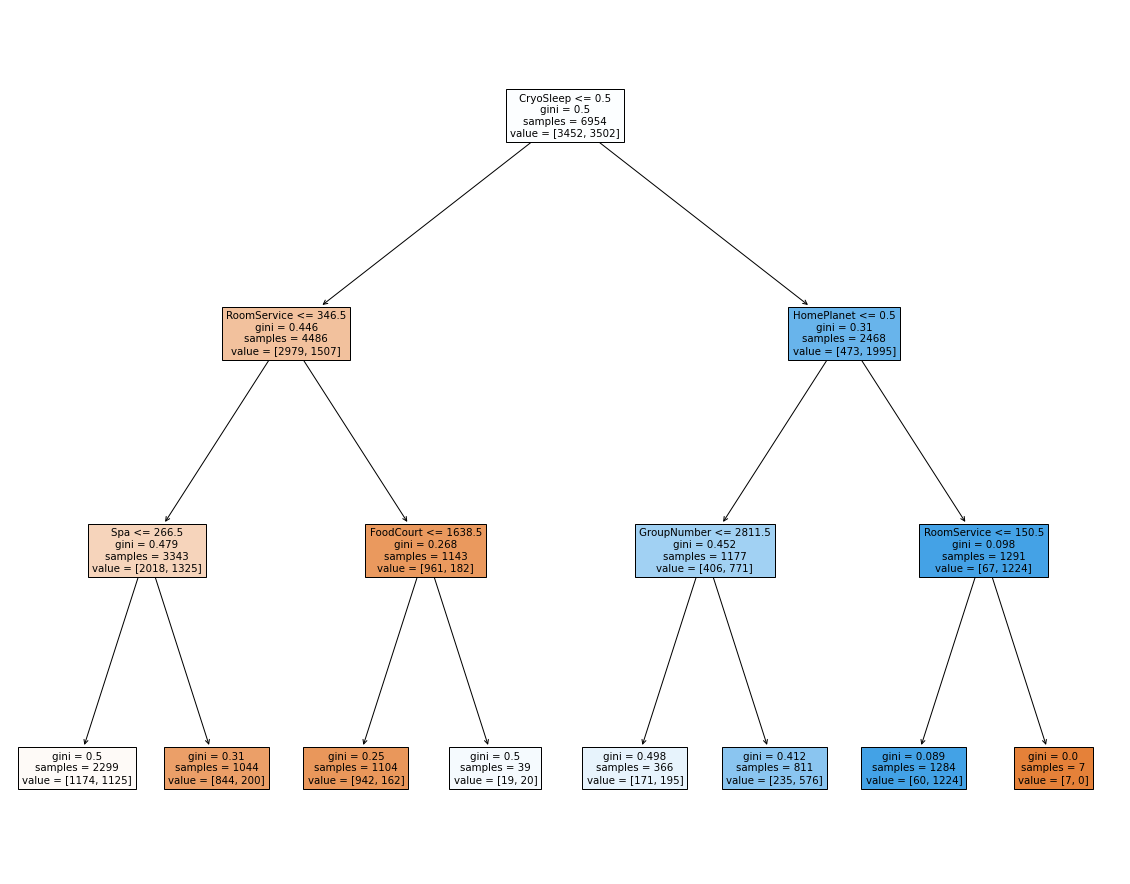

In [27]:
## Creating a plot tree to find new feature relationships

## Defining the input and target variables
X = train.drop(columns = ['Transported'])
Y = train['Transported']

## Splitting the data
X_training, X_validation, Y_training, Y_validation = train_test_split(X, Y, test_size = 0.2, stratify = Y)

## Building a decision tree model with max depth = 3 on the train data-frame
tree_md = DecisionTreeClassifier(max_depth = 3).fit(X_training, Y_training)

## Visualizing the decision tree model and identify any interesting interactions/features
fig = plt.figure(figsize = (20, 16))
plot_tree(tree_md, feature_names = X.columns, filled = True)

In [28]:
train['Tree_1'] = np.where((train['CryoSleep'] <= 0.5) & (test['RoomService'] <= 346.5) & (train['Spa'] <= 266.5), 0, 1)
train['Tree_2'] = np.where((train['CryoSleep'] <= 0.5) & (test['RoomService'] <= 346.5) & (train['Spa'] > 266.5), 0, 1)
train['Tree_3'] = np.where((train['CryoSleep'] <= 0.5) & (test['RoomService'] > 346.5) & (train['FoodCourt'] <= 1638.5), 0, 1)
train['Tree_4'] = np.where((train['CryoSleep'] <= 0.5) & (test['RoomService'] > 346.5) & (train['FoodCourt'] > 1638.5), 0, 1)
train['Tree_5'] = np.where((train['CryoSleep'] > 0.5) & (test['HomePlanet'] <= 0.5) & (train['GroupNumber'] <= 2811.5), 0, 1)
train['Tree_6'] = np.where((train['CryoSleep'] > 0.5) & (test['HomePlanet'] <= 0.5) & (train['GroupNumber'] > 2811.5), 0, 1)
train['Tree_7'] = np.where((train['CryoSleep'] > 0.5) & (test['HomePlanet'] > 0.5) & (train['RoomService'] <= 150.5), 0, 1)
train['Tree_8'] = np.where((train['CryoSleep'] > 0.5) & (test['HomePlanet'] > 0.5) & (train['RoomService'] > 150.5), 0, 1)

test['Tree_1'] = np.where((test['CryoSleep'] <= 0.5) & (test['RoomService'] <= 346.5) & (test['Spa'] <= 266.5), 0, 1)
test['Tree_2'] = np.where((test['CryoSleep'] <= 0.5) & (test['RoomService'] <= 346.5) & (test['Spa'] > 266.5), 0, 1)
test['Tree_3'] = np.where((test['CryoSleep'] <= 0.5) & (test['RoomService'] > 346.5) & (test['FoodCourt'] <= 1638.5), 0, 1)
test['Tree_4'] = np.where((test['CryoSleep'] <= 0.5) & (test['RoomService'] > 346.5) & (test['FoodCourt'] > 1638.5), 0, 1)
test['Tree_5'] = np.where((test['CryoSleep'] > 0.5) & (test['HomePlanet'] <= 0.5) & (test['GroupNumber'] <= 2811.5), 0, 1)
test['Tree_6'] = np.where((test['CryoSleep'] > 0.5) & (test['HomePlanet'] <= 0.5) & (test['GroupNumber'] > 2811.5), 0, 1)
test['Tree_7'] = np.where((test['CryoSleep'] > 0.5) & (test['HomePlanet'] > 0.5) & (test['RoomService'] <= 150.5), 0, 1)
test['Tree_8'] = np.where((test['CryoSleep'] > 0.5) & (test['HomePlanet'] > 0.5) & (test['RoomService'] > 150.5), 0, 1)

### Feature Selection

In [29]:
## Defining the input and target variables
X = train.drop(columns = ['Transported'])
Y = train['Transported']

## Splitting the data into training, validation, and testing sets
X_training, X_validation, Y_training, Y_validation = train_test_split(X, Y, test_size = 0.2, stratify = Y)

In [30]:
## RFECV with RandomForest

## Defining an empty list to store results
rfecv_results = []

## Repeating the process 20 times
for i in tqdm(range(0, 20)):
    
    ## Building the RFECV model
    rf_rfecv = RFECV(estimator = RandomForestClassifier(), step = 1, min_features_to_select = 2, 
                        cv = 3, scoring = 'accuracy').fit(X_training, Y_training)
    
    ## Appending results to list
    rfecv_results.append(rf_rfecv.support_)
    
## Returning results of RFECV
rf = pd.DataFrame(rfecv_results, columns = X_training.columns)
rf = 100 * rf.apply(np.sum, axis = 0) / rf.shape[0]
pd.DataFrame(rf).sort_values(0, ascending = False).T

100%|██████████| 50/50 [53:59<00:00, 64.80s/it]


,HomePlanet,GroupNumber,Interaction_6,Interaction_5,Interaction_4,CryoSleep,Deck,GroupTotal,GroupPerson,Side,VRDeck,RoomService,Destination,Spa,Age,FoodCourt,ShoppingMall,Tree_1,Tree_2,Tree_7,Tree_3,Tree_5,VIP,Tree_6,Interaction_1,Interaction_2,Tree_4,Interaction_3,Tree_8
0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,82.0,46.0,30.0,24.0,10.0,6.0,6.0,4.0,4.0,4.0,2.0,0.0


In [33]:
## RFECV with XGBoost

## Defining an empty list to store results
rfecv_results = []

## Repeating the process 20 times
for i in tqdm(range(0, 20)):
    
    ## Building the RFECV model
    xgb_rfecv = RFECV(estimator = XGBClassifier(eval_metric = 'error', use_label_encoder = False), step = 1, min_features_to_select = 2, 
                        cv = 3, scoring = 'accuracy').fit(X_training, Y_training)
    
    ## Appending results to list
    rfecv_results.append(xgb_rfecv.support_)
    
## Returning results of RFECV
xgb = pd.DataFrame(rfecv_results, columns = X_training.columns)
xgb = 100 * xgb.apply(np.sum, axis = 0) / xgb.shape[0]
pd.DataFrame(xgb).sort_values(0, ascending = False).T

  0%|          | 0/20 [00:26<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
## Subsetting the data for the RandomForest and XGBoost models

X_rf_train = train[[]]
X_rf_test = test[[]]

X_xgb_train = train[[]]
X_xgb_test = test[[]]

In [ ]:
Check variables first

### Hyper-Parameter Tuning

In [ ]:
## Defining the input and target variables
X = train.drop(columns = ['Transported'])
Y = train['Transported']

## Splitting the data
X_training, X_validation, Y_training, Y_validation = train_test_split(X, Y, test_size = 0.2, stratify = Y)

In [ ]:
## Completing hyper-parameter tuning with Random Forest on the validation set

## Defining the parameter dictionary
rf_param_grid = {'n_estimators': [100, 300, 500], 'max_depth': [3, 5, 7], 'min_samples_split': [5, 10, 15], 
                  'min_samples_leaf': [5, 10, 15]}

## Running GridSearchCV with 3 folds
rf_grid_search = GridSearchCV(RandomForestClassifier(), rf_param_grid, cv = 3, scoring = 'accuracy', n_jobs = -1).fit(X_validation, Y_validation)

## Extracting the best hyper-parameters
print('Optimal hyper-parameters for Random Forest Model: \n', rf_grid_search.best_params_)
print('\nBest accracy score:\n', round(rf_grid_search.best_score_ * 100, 2), '%')

In [ ]:
## Completing hyper-parameter tuning with XGBoost on the validation set

## Defining the parameter dictionary
xgb_param_grid = {'n_estimators': [300, 500], 'max_depth': [5, 7], 'min_child_weight': [5, 7], 
                  'learning_rate' : [0.01, 0.001], 'gamma': [0.1, 0.01], 'subsample': [0.8, 1], 
                  'colsample_bytree': [0.8, 1], 'early_stopping_rounds': [100]}

## Running GridSearchCV with 3 folds
xgb_grid_search = GridSearchCV(XGBClassifier(eval_metric = 'error', use_label_encoder = False), xgb_param_grid, cv = 3, scoring = 'accuracy', 
                               n_jobs = -1).fit(X_validation, Y_validation)

## Extracting the best hyper-parameters
print('Optimal hyper-parameters for XGBoost Model: \n', xgb_grid_search.best_params_)
print('\nBest accuracy score:\n', round(xgb_grid_search.best_score_ * 100, 2), '%')

### Final Modeling

In [ ]:
## Defining the input and target variables
X = train.drop(columns = ['Transported'])
Y = train['Transported']

## Splitting the data
X_training, X_validation, Y_training, Y_validation = train_test_split(X, Y, test_size = 0.2, stratify = Y)

In [ ]:
## Building a Random Forest model with the optimal hyper-parameters
rf_md = RandomForestClassifier(max_depth = 5, min_samples_leaf = 15, min_samples_split = 10, 
                               n_estimators = 300).fit(X_training, Y_training)

## Predicting on the validation set
rf_preds = rf_md.predict_proba(X_validation)[:, 1]

## Extracting estimated labels using the PRC function
rf_labels = threshold_scoring.auc_roc_cutoff(Y_validation, rf_preds)

## Extracting optimal cutoff using the PRC function
rf_cutoff = threshold_scoring.auc_roc_cutoff_cutoff(Y_validation, rf_preds)

## Reporting the optimal cutoff value
print('Optimal Cutoff of Random Forest Model:', round(rf_cutoff, 3))

## Reporting the classification report of the model
print('\nClassification Report of Random Forest Model:', classification_report(Y_validation, rf_labels))

## Predicting on the test set
rf_test_preds = rf_md.predict_proba(X_test)[:, 1]

## Extracting estimated labels using the optimal cutoff value
rf_test_labels = np.where(rf_test_preds < rf_cutoff, False, True)

## Creating new data frame for test set results
rf_predictions = pd.DataFrame({'PassengerId': test['PassengerId'], 'Transported': rf_test_labels})

## Returning predicted labels as a csv file
rf_predictions.to_csv('rf_predictions.csv', index = False)

In [ ]:
## Building a XGBoost model with the optimal hyper-parameters


### Meta-Learner